In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.layers import *
from keras.models import Model

from keras import backend as K

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess = tf.Session()
tf.keras.backend.set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)


batch_size = 64
latent_dim = 8
num_classes = 10
shape = (28, 28, 1)
gamma = 1



def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while(True):
        idxs = np.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]
        for i in range(n_batches):
            yield x[batch_size*i: batch_size*(i+1)], y[batch_size*i: batch_size*(i+1)]

train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it  = gen_batch(x_test,  y_test_cat)


In [ ]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='image')
y_ = tf.placeholder(tf.float32, shape=(None, 10), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z   = Input(tensor=z_)

In [3]:
x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(img)
x = LeakyReLU()(x)
x = MaxPool2D((2, 2), padding='same')(x)

x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = LeakyReLU()(x)

x = Flatten()(x)
x = concatenate([x, lbl])

h = Dense(64)(x)
h = LeakyReLU()(h)

z_mean    = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(K.clip(z_log_var/2, -2, 2)) * epsilon
l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model([img, lbl], [z_mean, z_log_var, l], name='Encoder')

In [4]:
x = concatenate([z, lbl])
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7, 7, 128))(x)
x = UpSampling2D(size=(2, 2))(x)

x = Conv2D(64, kernel_size=(5, 5), padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
x = LeakyReLU()(x)

decoded = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
decoder = Model([z, lbl], decoded, name='Decoder')

In [5]:
x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
x = MaxPool2D((2, 2), padding='same')(x)
x = LeakyReLU()(x)

repeat = RepeatVector(int(x.shape[1]) * int(x.shape[2]))(lbl)
repeat = Reshape((x.shape[1], x.shape[2], lbl.shape[1]))(repeat)
x = concatenate([x, repeat])

x = Conv2D(64, kernel_size=(3, 3), padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = LeakyReLU()(x)

l = Conv2D(16, kernel_size=(3, 3), padding='same')(x)
x = LeakyReLU()(x)

h = Flatten()(x)
d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], [d, l], name='Discriminator')

In [6]:
z_mean, z_log_var, encoded_img = encoder([img, lbl])

decoded_img = decoder([encoded_img, lbl])
decoded_z   = decoder([z, lbl])

discr_img,     discr_l_img     = discrim([img, lbl])
discr_dec_img, discr_l_dec_img = discrim([decoded_img, lbl])
discr_dec_z,   discr_l_dec_z   = discrim([decoded_z, lbl])

cvae_model = Model([img, lbl], decoder([encoded_img, lbl]), name='cvae')
cvae =  cvae_model([img, lbl])

In [7]:
L_prior = -0.5*tf.reduce_sum(1. + tf.clip_by_value(z_log_var, -2, 2) - tf.square(z_mean) - tf.exp(tf.clip_by_value(z_log_var, -2, 2)))/28/28

log_dis_img = tf.log(discr_img + 1e-10)
log_dis_dec_z = tf.log(1. - discr_dec_z + 1e-10)
log_dis_dec_img = tf.log(1. - discr_dec_img + 1e-10)

L_GAN = -1/4*tf.reduce_sum(log_dis_img + 2*log_dis_dec_z + log_dis_dec_img)/28/28

L_dis_llike = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.sigmoid(discr_l_img),
                                                                    logits=discr_l_dec_img))/28/28

L_enc = L_dis_llike + L_prior
L_dec = gamma * L_dis_llike - L_GAN
L_dis = L_GAN


opt_enc = tf.train.RMSPropOptimizer(0.001)
opt_dec = tf.train.RMSPropOptimizer(0.0001)
opt_dis = tf.train.RMSPropOptimizer(0.001)


step_enc = opt_enc.minimize(L_enc, var_list=encoder.trainable_weights)
step_dec = opt_dec.minimize(L_dec, var_list=decoder.trainable_weights)
step_dis = opt_dis.minimize(L_dis, var_list=discrim.trainable_weights)


def step(image, label, zp):
    l_prior, dec_image, l_dis_llike, l_gan, _, _ = sess.run([L_prior, decoded_z, L_dis_llike, L_GAN, step_enc, step_dec],
                                                            feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_prior, dec_image, l_dis_llike, l_gan

def step_d(image, label, zp):
    l_gan, _ = sess.run([L_GAN, step_dis], feed_dict={z:zp, img:image, lbl:label, K.learning_phase():1})
    return l_gan


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
def display_digits():
    n = 10
    num = 2
    b = next(test_batches_it)
    decoded = sess.run(cvae, feed_dict={img:b[0], lbl:b[1], K.learning_phase():0})


    digit_size = 28

    figure = np.zeros((digit_size * num, digit_size * n))

    for i in range(n):
        for j in range(num):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = b[0][:n][i].reshape(digit_size, digit_size) if j == 0 else decoded[i].reshape(digit_size, digit_size)


    plt.figure(figsize=(2*n, 2*num))
    plt.imshow(figure, cmap='Greys_r')

    plt.show()

In [9]:
sess.run(tf.global_variables_initializer())

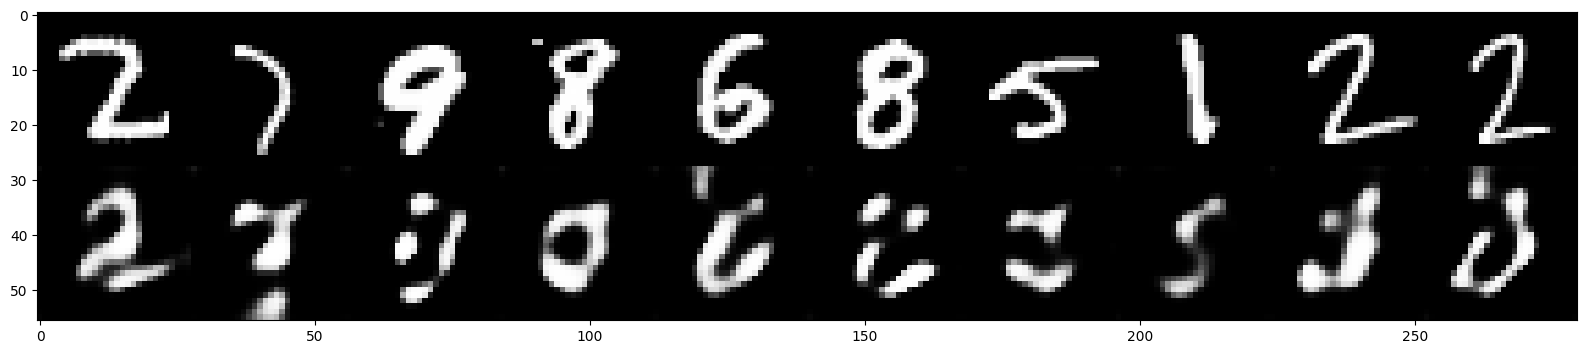

epochs:  0 loss:  7.738493e-06 14.40802 0.04027612


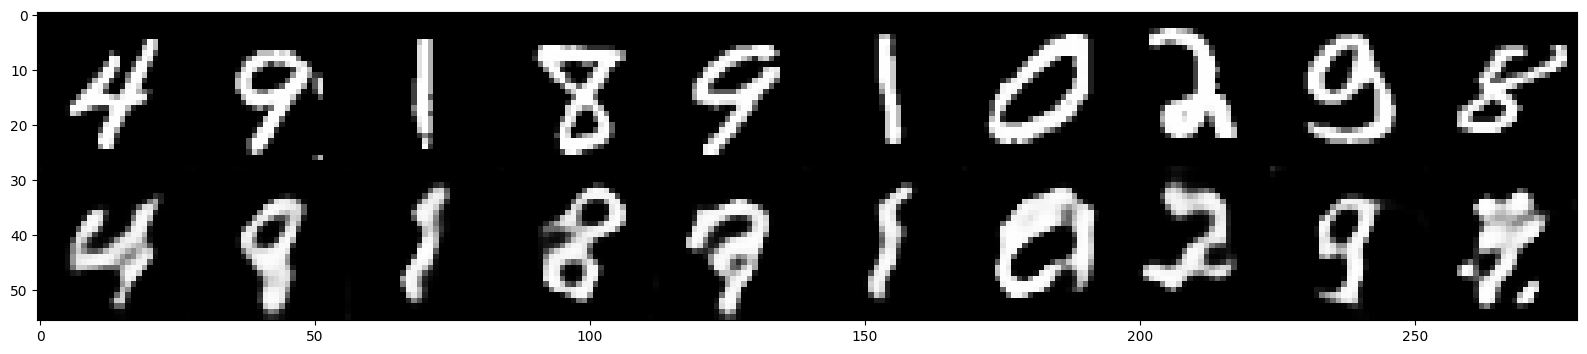

epochs:  1 loss:  0.0004147885 14.148531 0.033986073


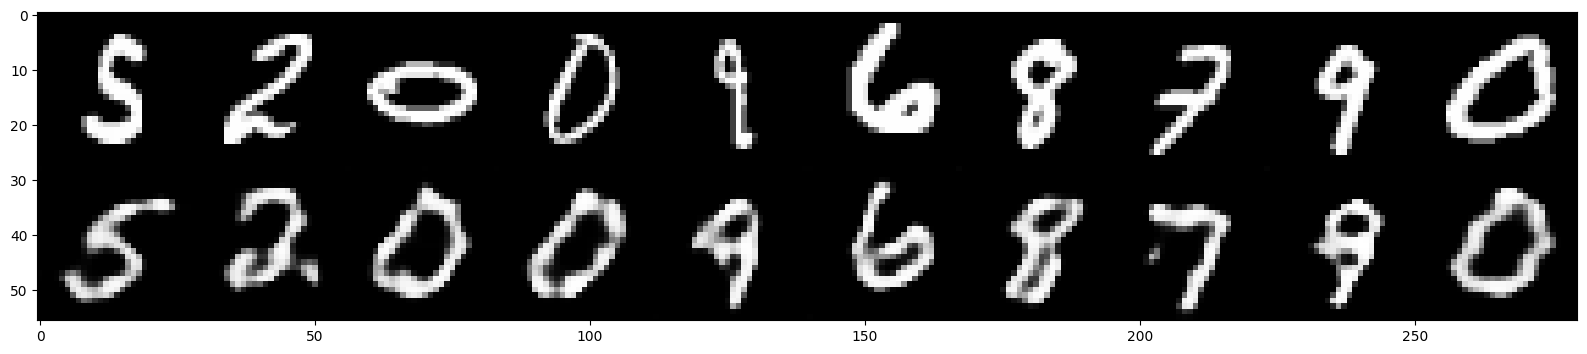

epochs:  2 loss:  0.013533036 13.187331 0.0090306755


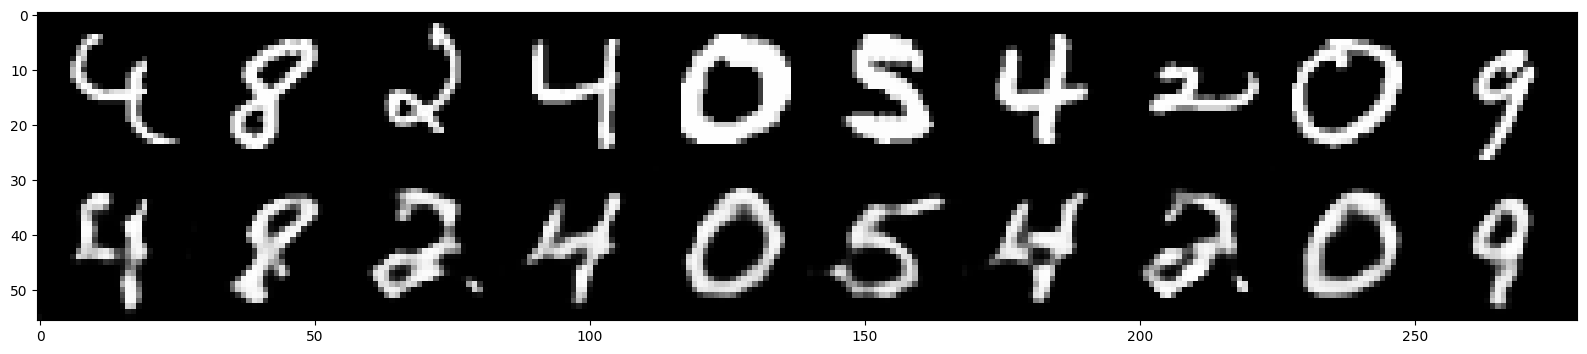

epochs:  3 loss:  0.028266784 12.70145 0.006027721


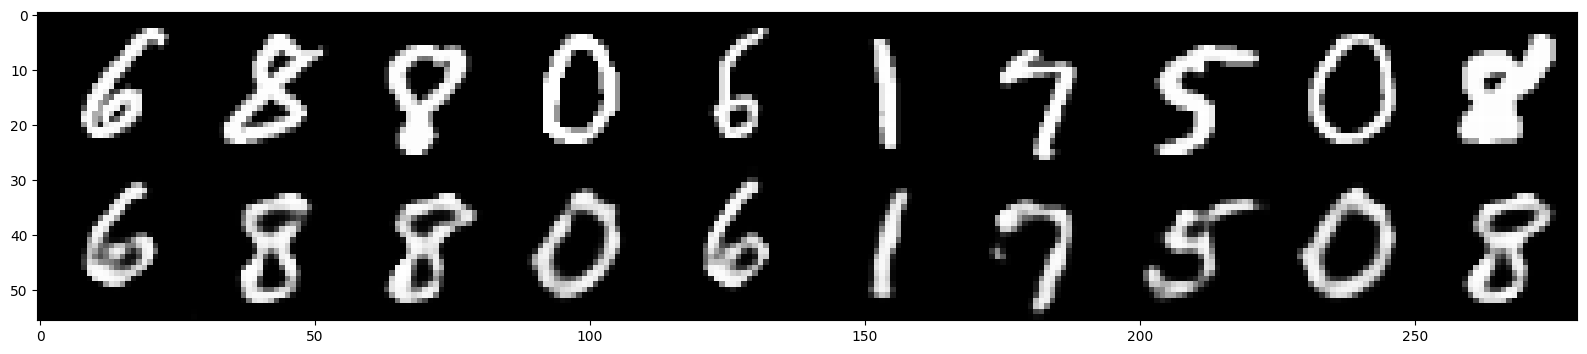

epochs:  4 loss:  0.04077852 12.527635 0.0028756598


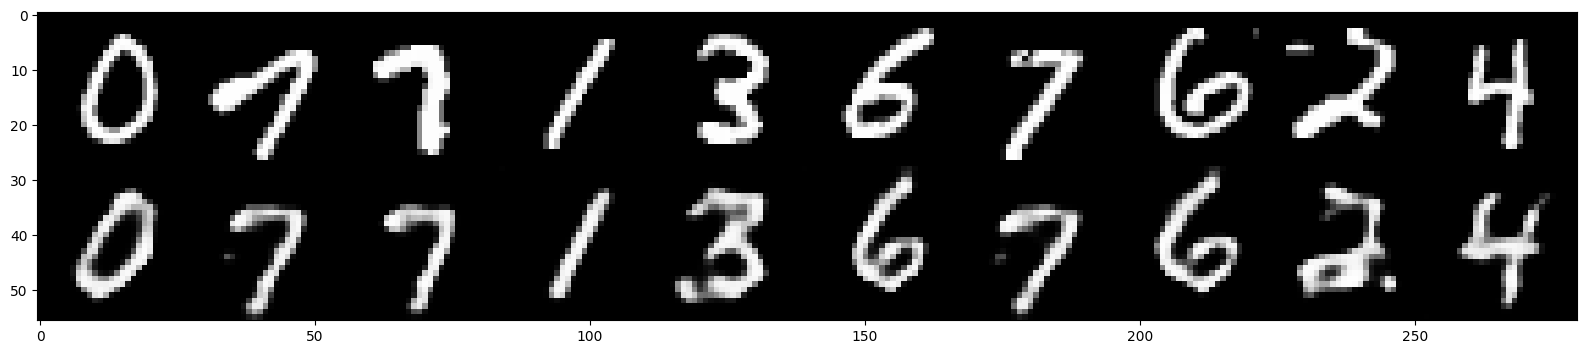

epochs:  5 loss:  0.08341256 12.375299 0.003945192


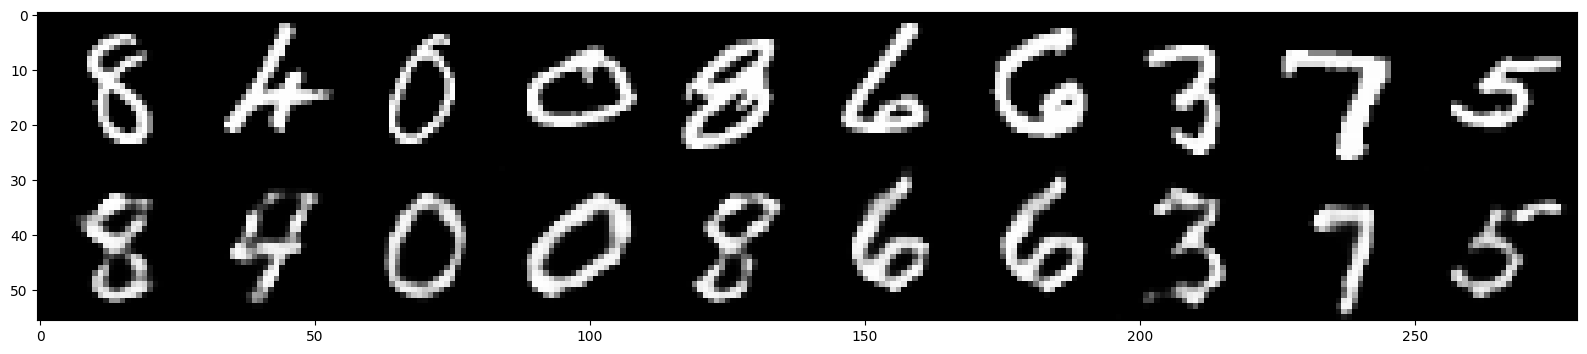

epochs:  6 loss:  0.10624483 12.278209 0.0045967484


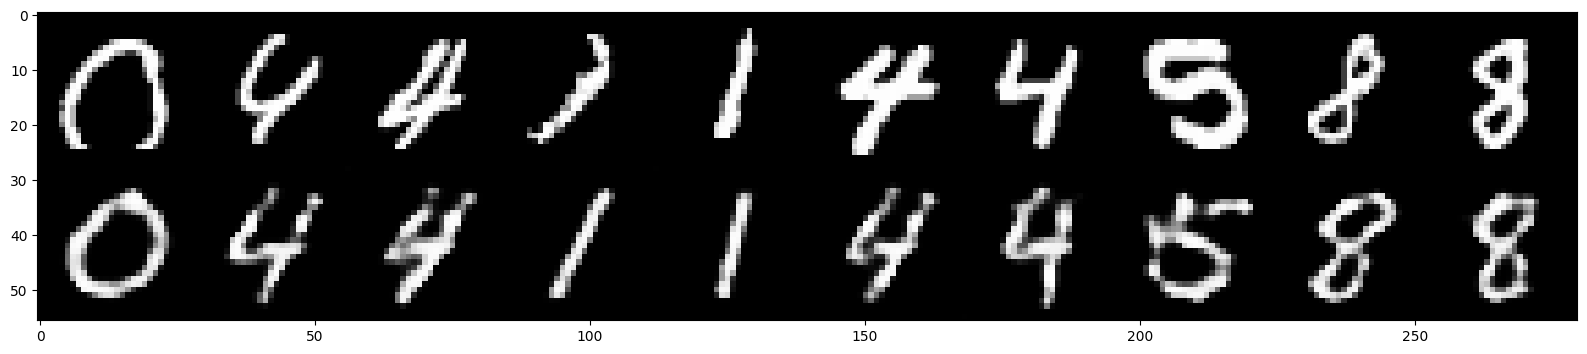

epochs:  7 loss:  0.11170846 12.158762 0.0028959026


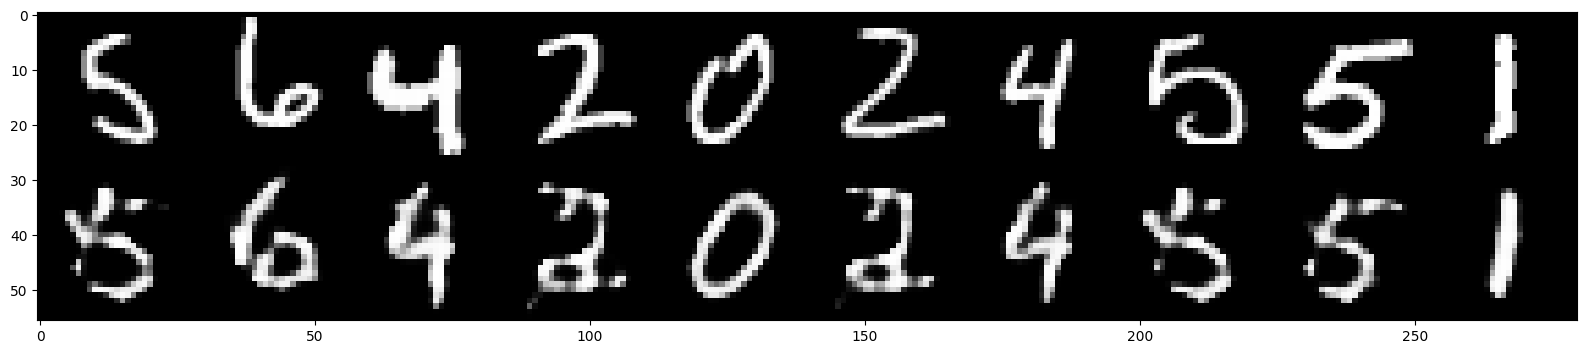

epochs:  8 loss:  0.118741445 12.248375 0.004364257


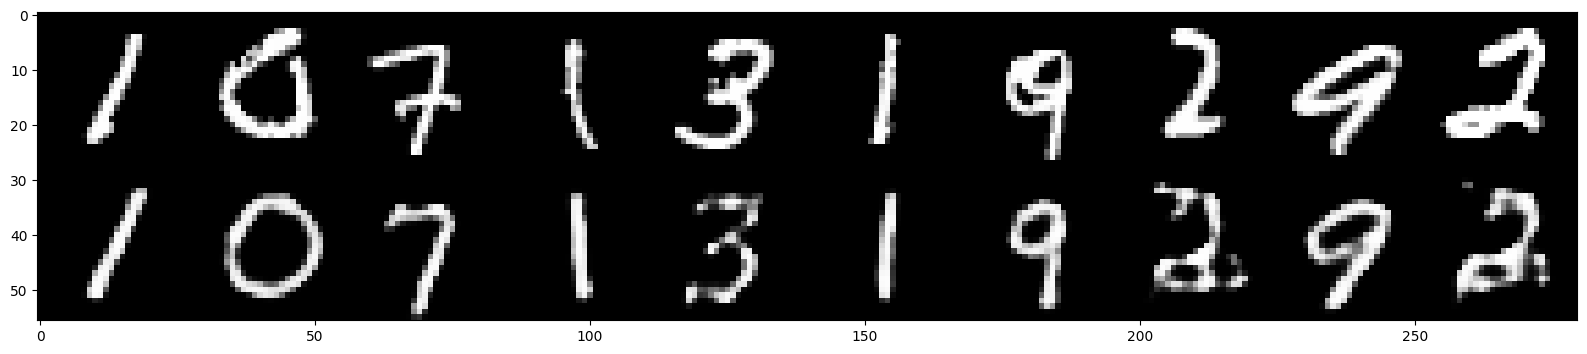

epochs:  9 loss:  0.112730816 12.602566 0.006556728


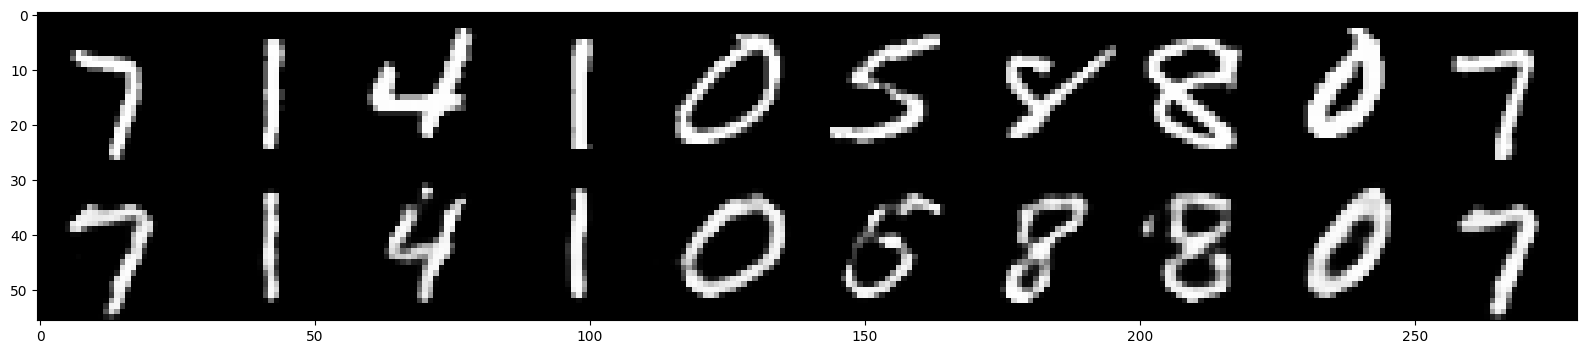

epochs:  10 loss:  0.13610849 12.59739 0.006031603


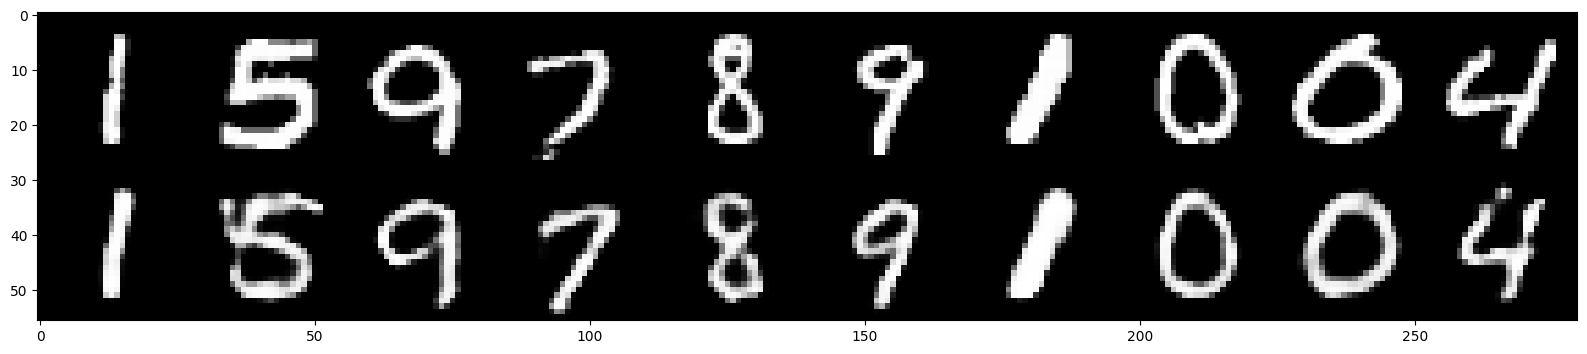

epochs:  11 loss:  0.1320423 12.450378 0.0040961043


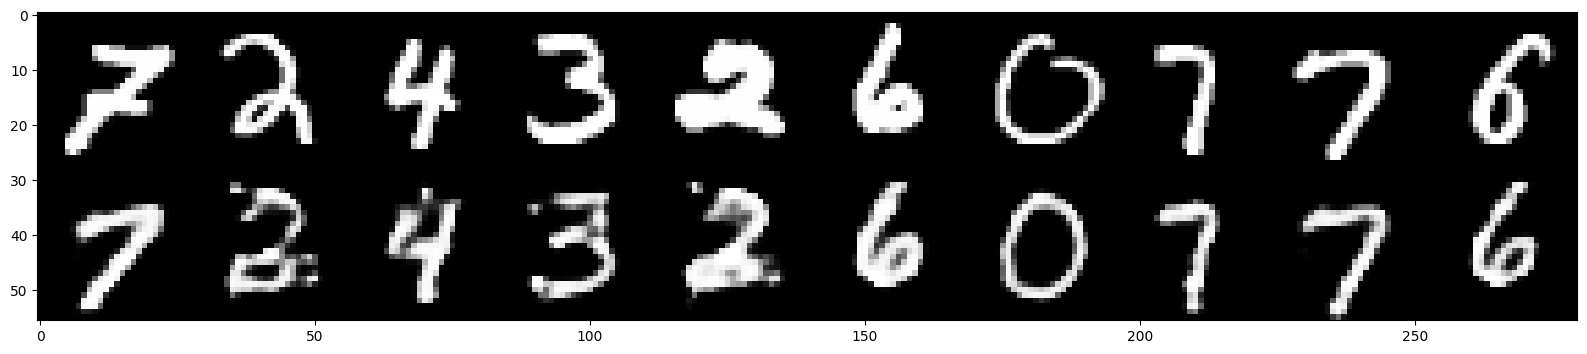

epochs:  12 loss:  0.15851079 12.42748 0.00887522


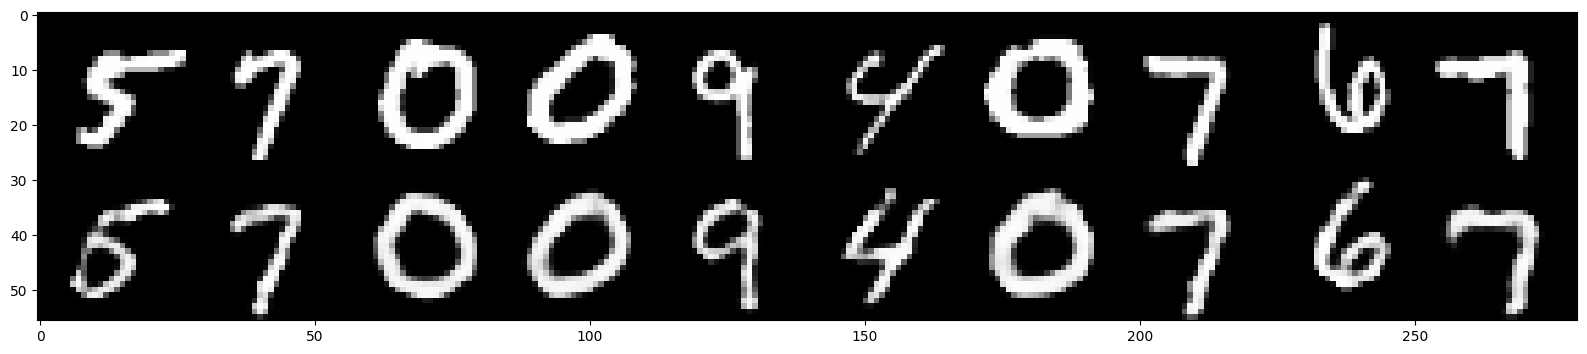

epochs:  13 loss:  0.14595024 12.280815 0.004715487


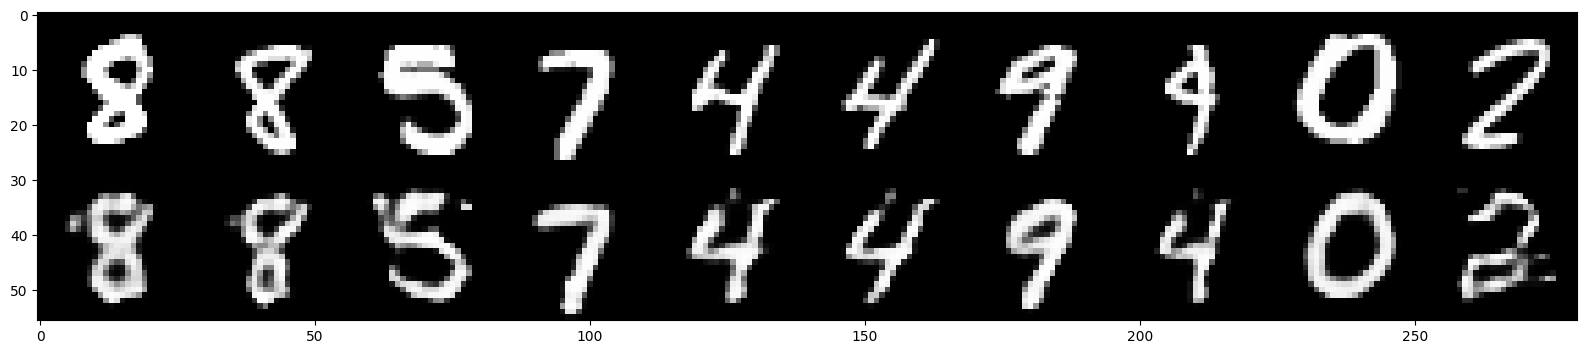

epochs:  14 loss:  0.15494898 12.092578 0.004129385


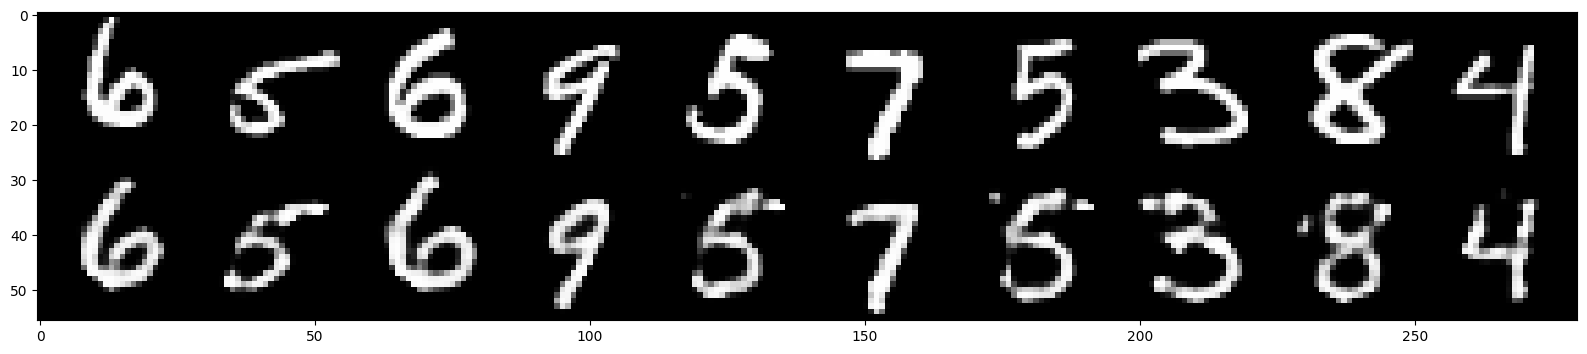

epochs:  15 loss:  0.17009482 12.037587 0.004570628


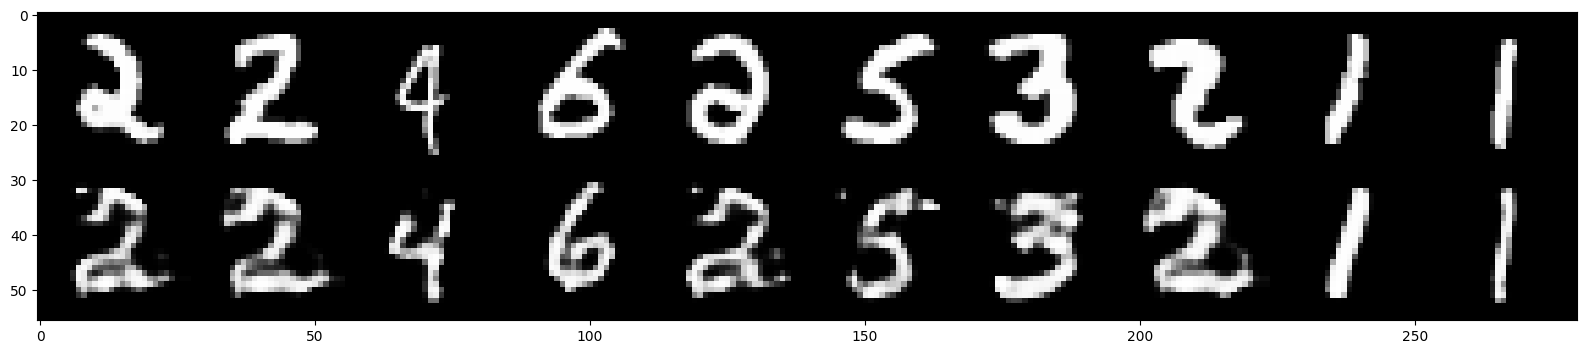

epochs:  16 loss:  0.19118723 12.0316515 0.008435621


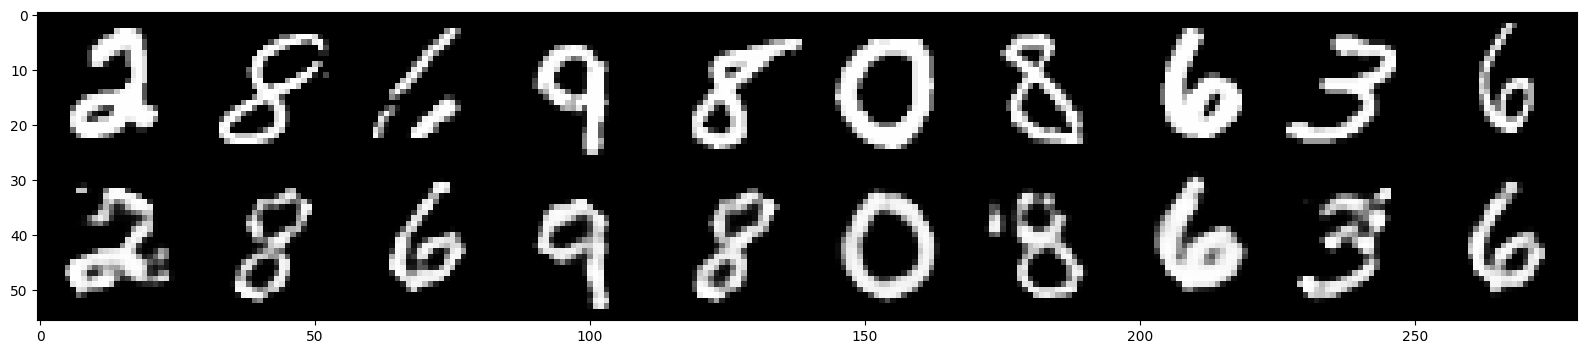

epochs:  17 loss:  0.16913612 12.001246 0.0026658908


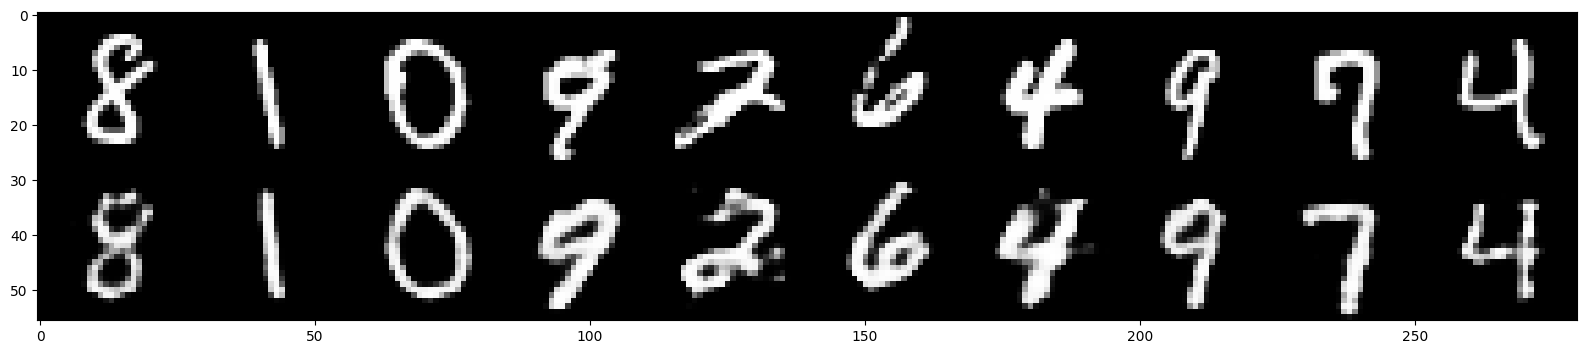

epochs:  18 loss:  0.19017255 12.025249 0.004623744


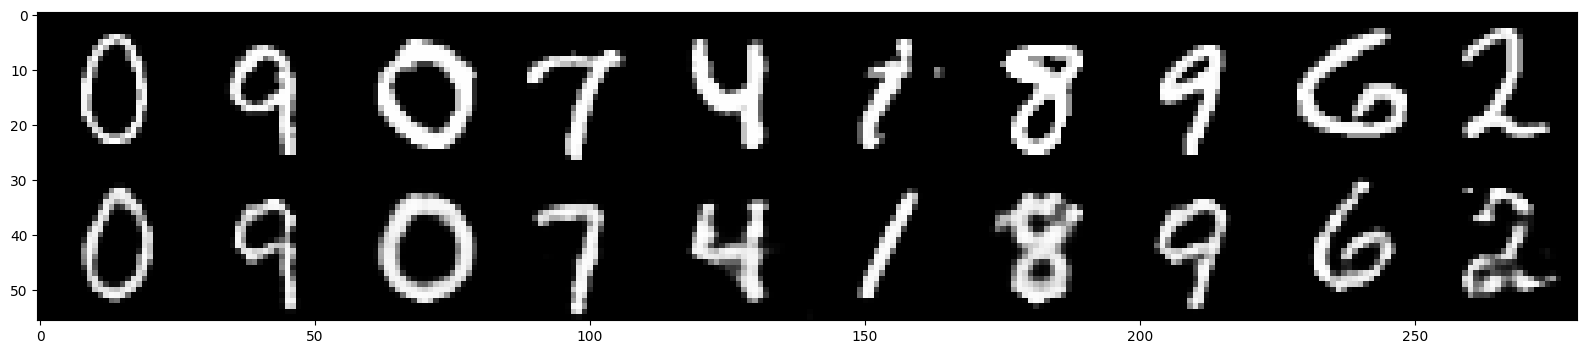

epochs:  19 loss:  0.18959543 11.959312 0.0038131315


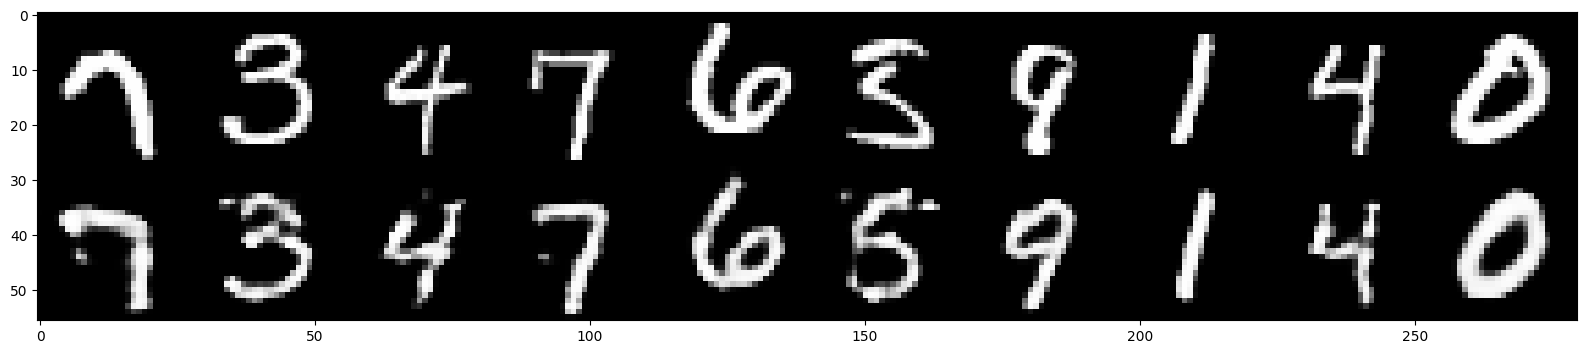

epochs:  20 loss:  0.1849733 11.985791 0.0025345695


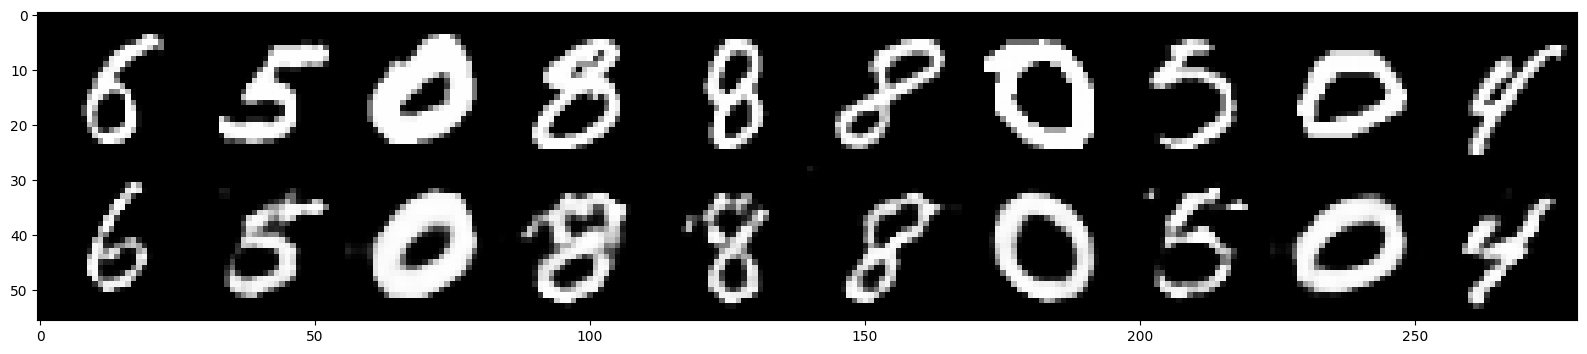

epochs:  21 loss:  0.20286128 12.080487 0.0033010058


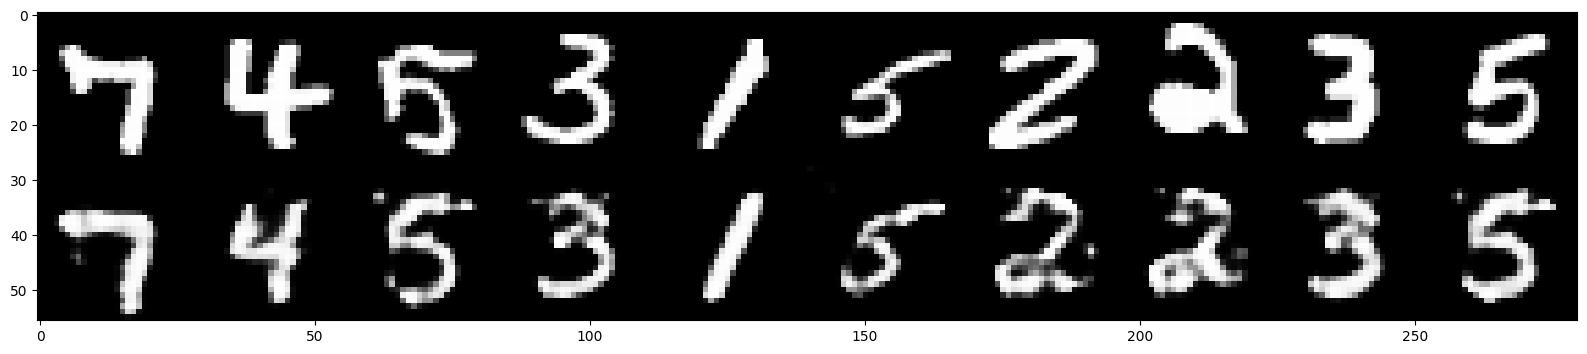

epochs:  22 loss:  0.21015544 11.833445 0.0035955259


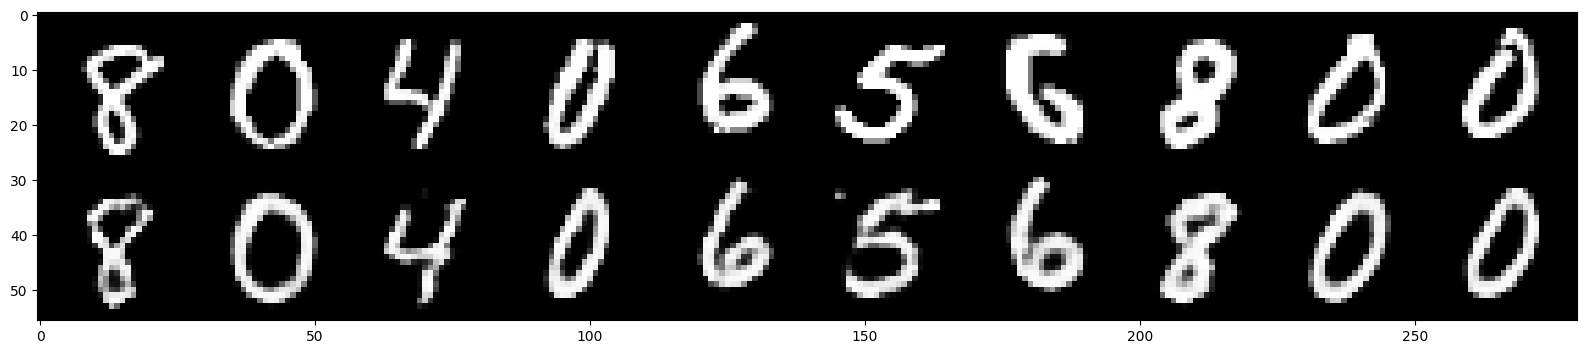

epochs:  23 loss:  0.21908754 11.888544 0.0032556744


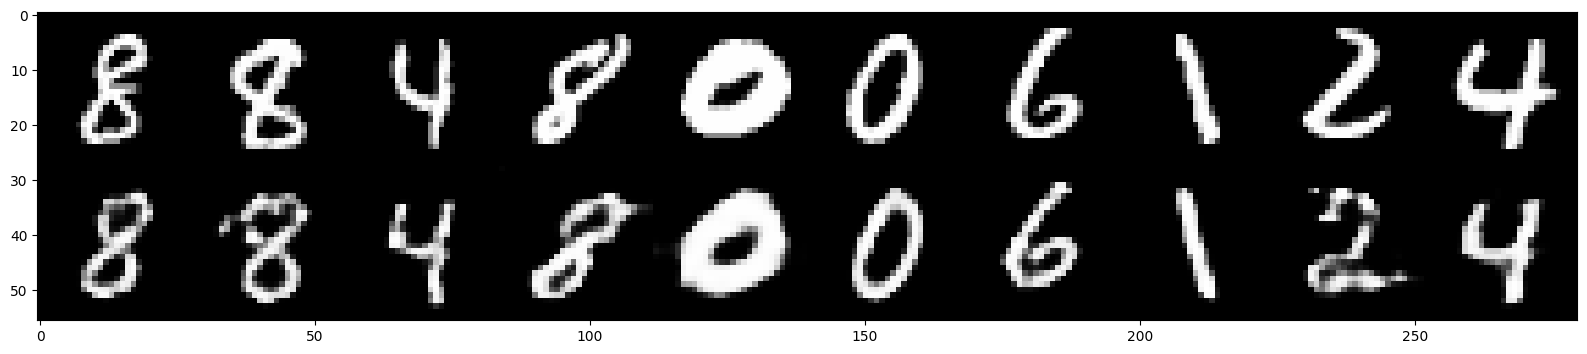

epochs:  24 loss:  0.20974149 12.079394 0.005959076


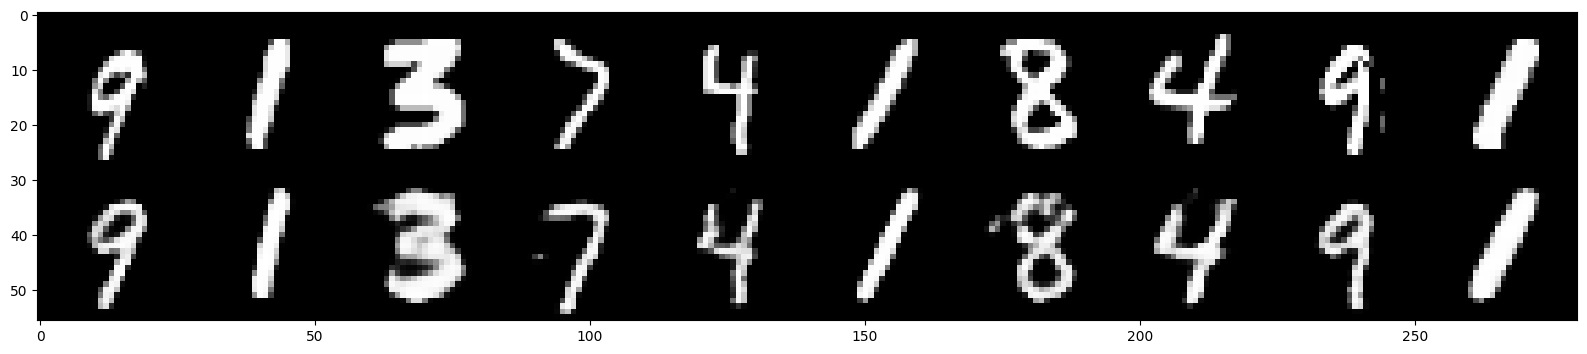

epochs:  25 loss:  0.2091671 12.014597 0.0034239665


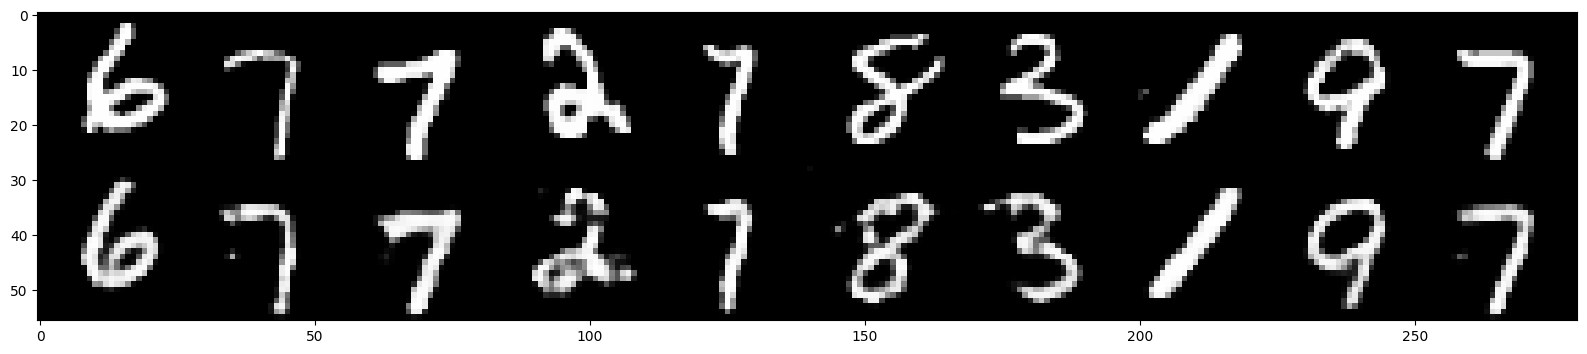

epochs:  26 loss:  0.21092953 11.911841 0.0036105711


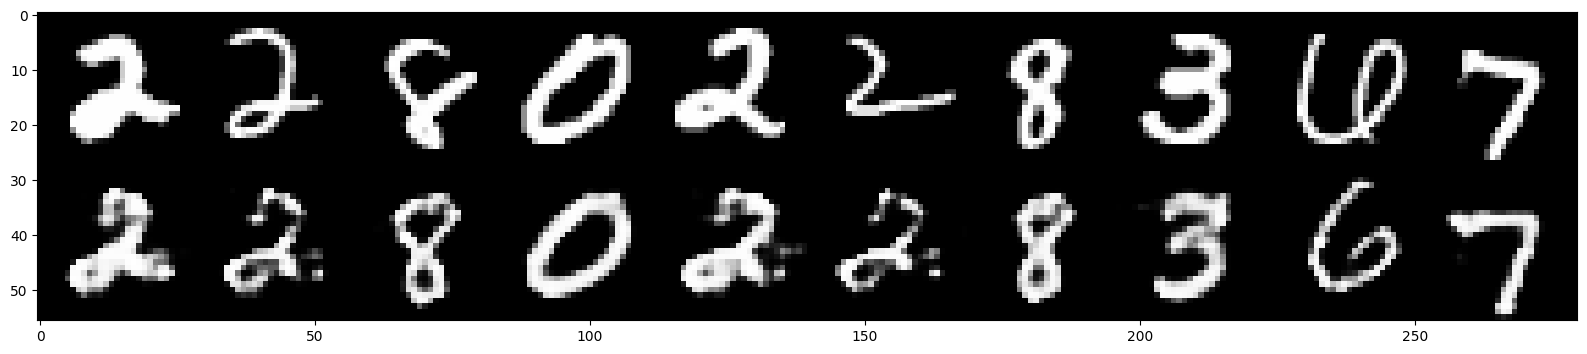

epochs:  27 loss:  0.21597952 11.86456 0.008336846


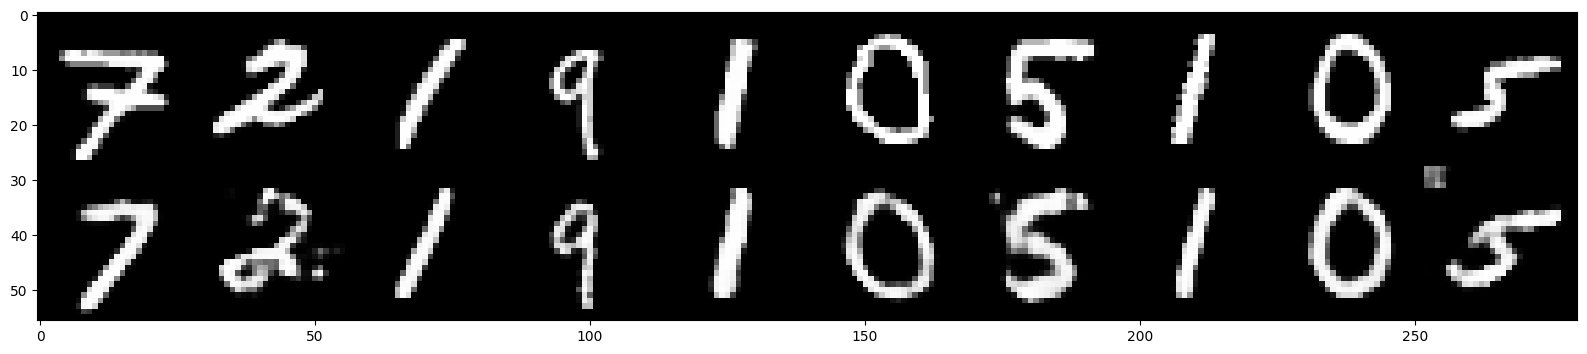

epochs:  28 loss:  0.21786298 11.9479885 0.002647739


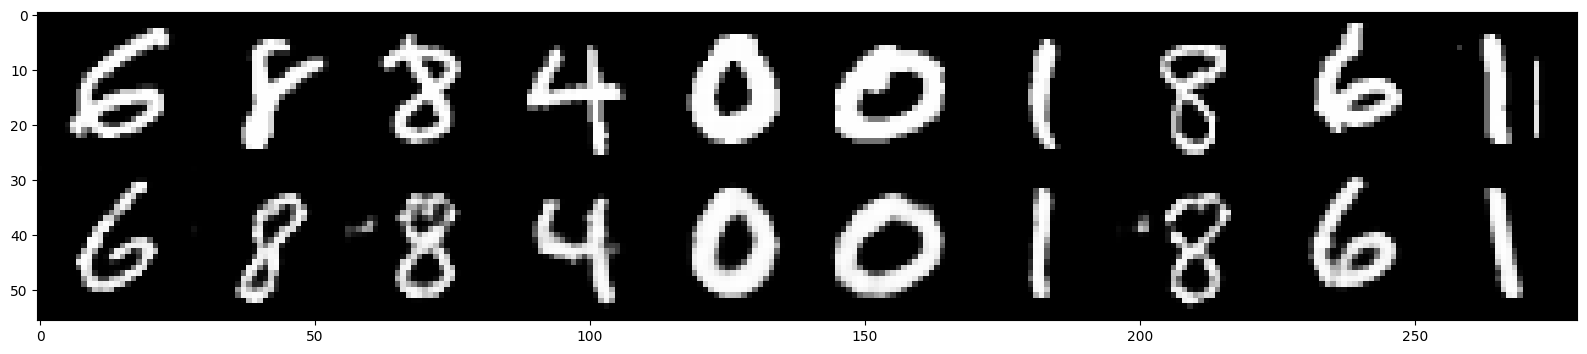

epochs:  29 loss:  0.23827149 11.728936 0.0041372078


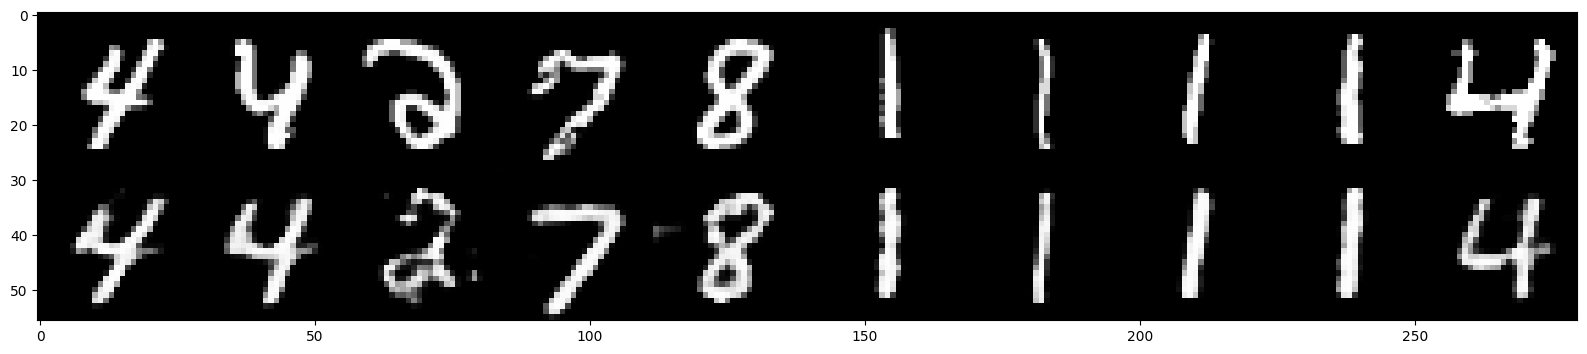

epochs:  30 loss:  0.22569528 11.863249 0.0031264056


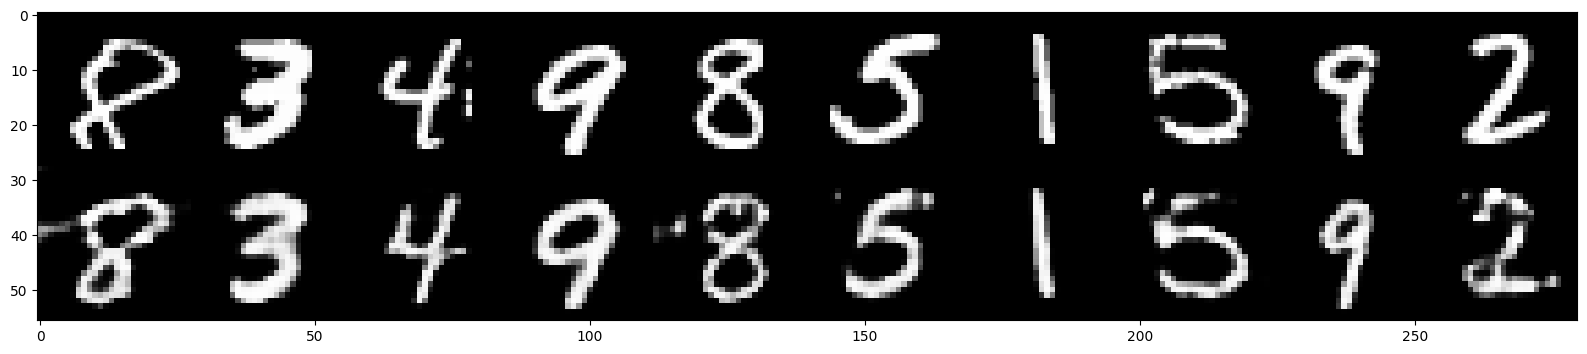

epochs:  31 loss:  0.2276072 12.02304 0.003954575


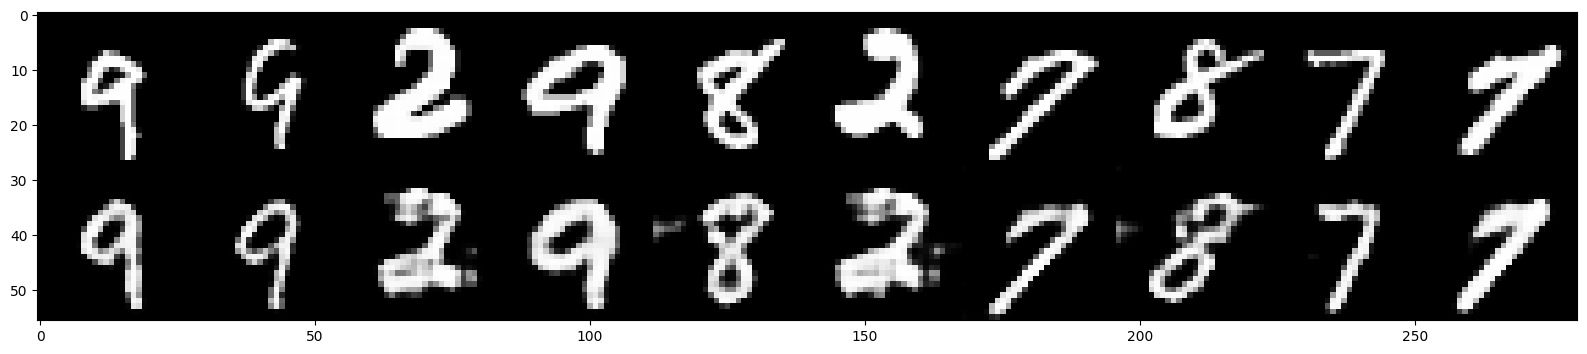

epochs:  32 loss:  0.2205676 12.070106 0.0048314715


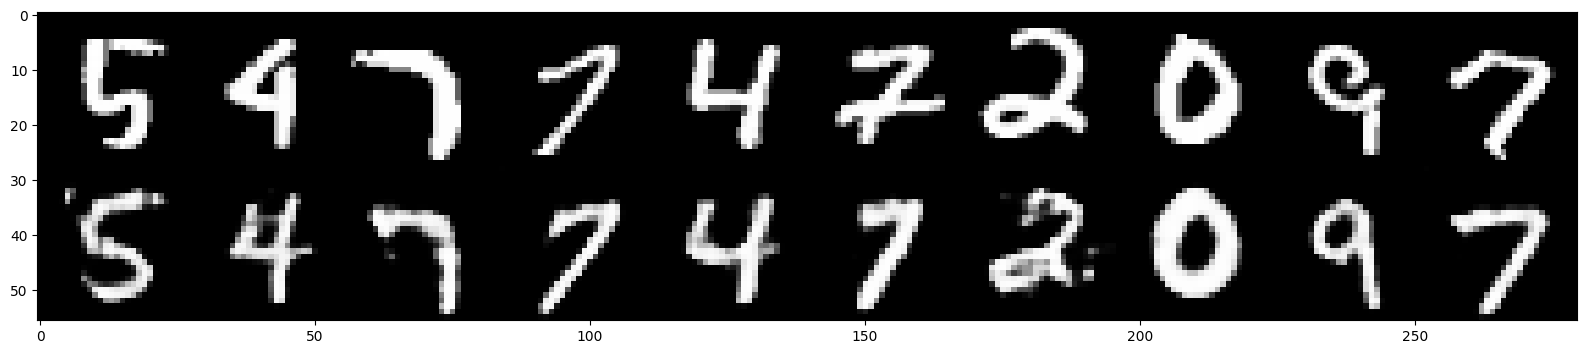

epochs:  33 loss:  0.24030247 11.906084 0.0024966416


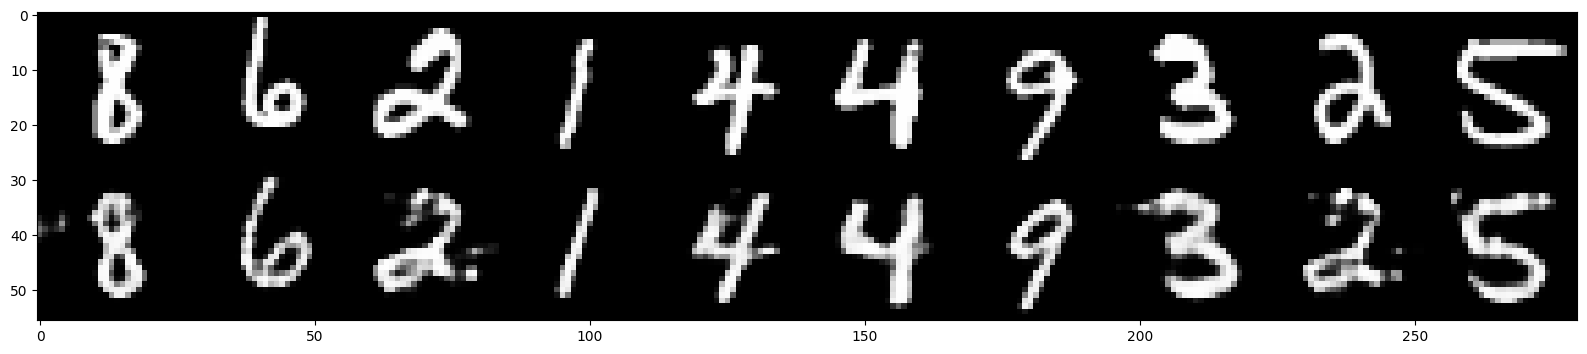

epochs:  34 loss:  0.23316315 11.984398 0.008506549


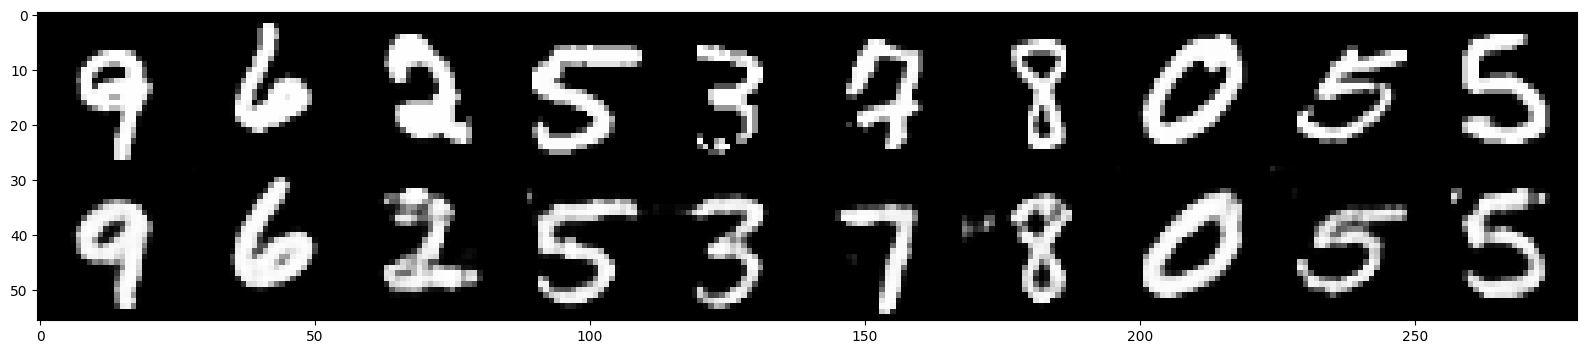

epochs:  35 loss:  0.23706572 12.083769 0.0057723196


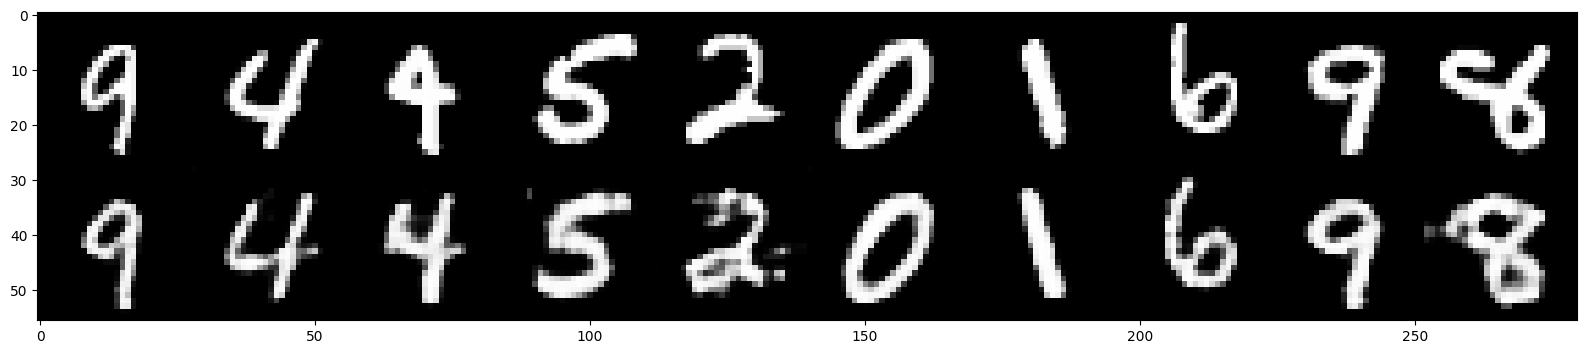

epochs:  36 loss:  0.23534434 11.839783 0.0029215876


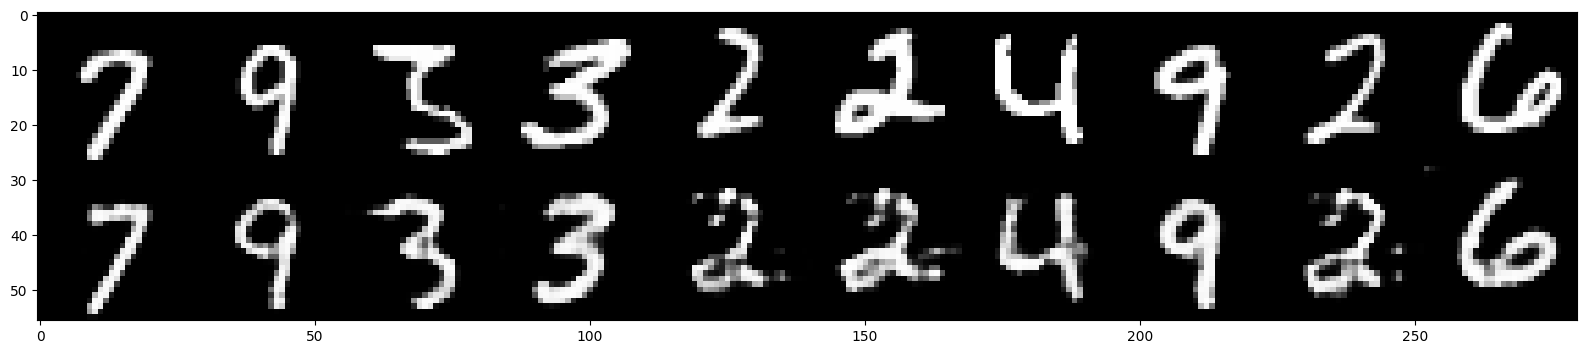

epochs:  37 loss:  0.24825282 11.759111 0.014639083


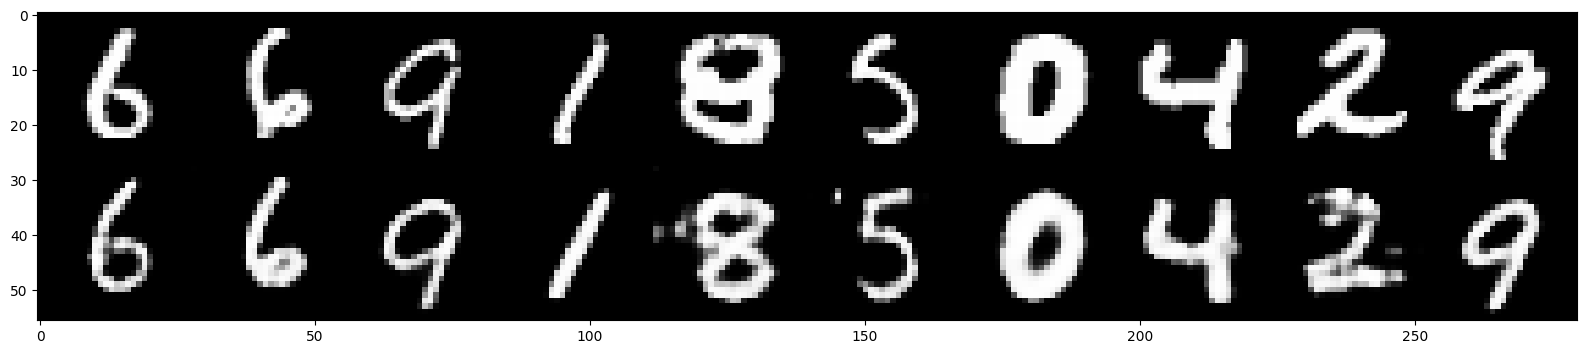

epochs:  38 loss:  0.2545229 11.914193 0.010290145


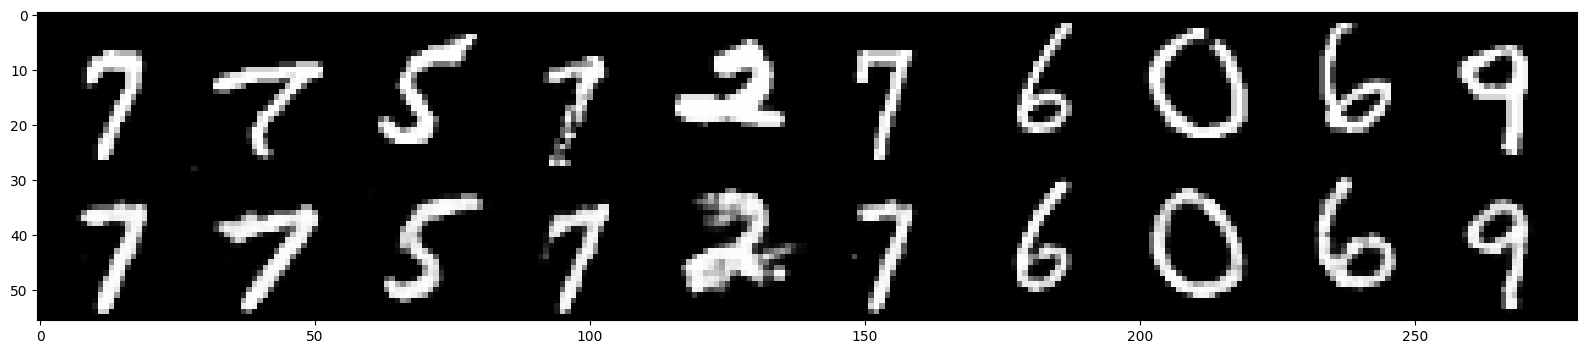

epochs:  39 loss:  0.24966861 11.81316 0.001830504


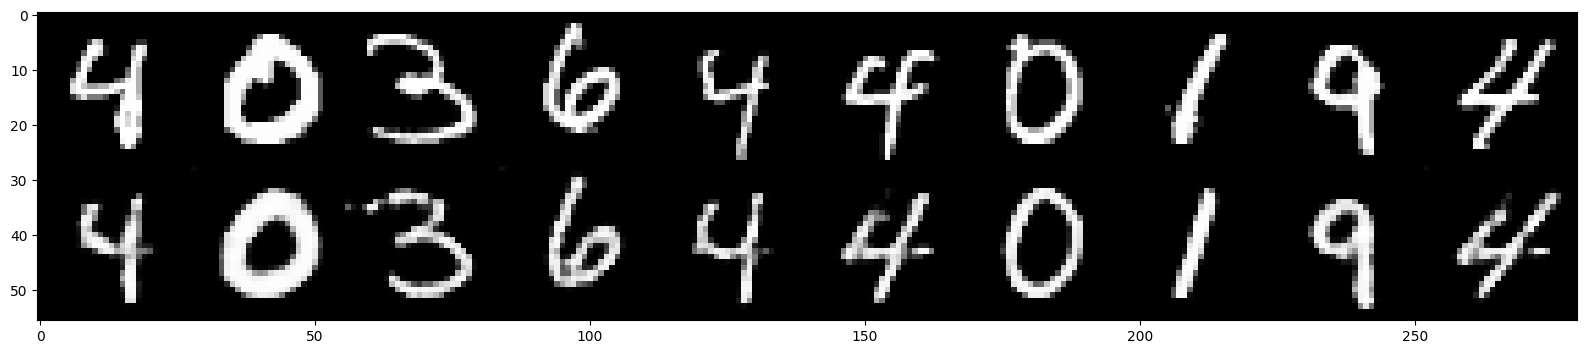

epochs:  40 loss:  0.25261953 11.837855 0.0015475627


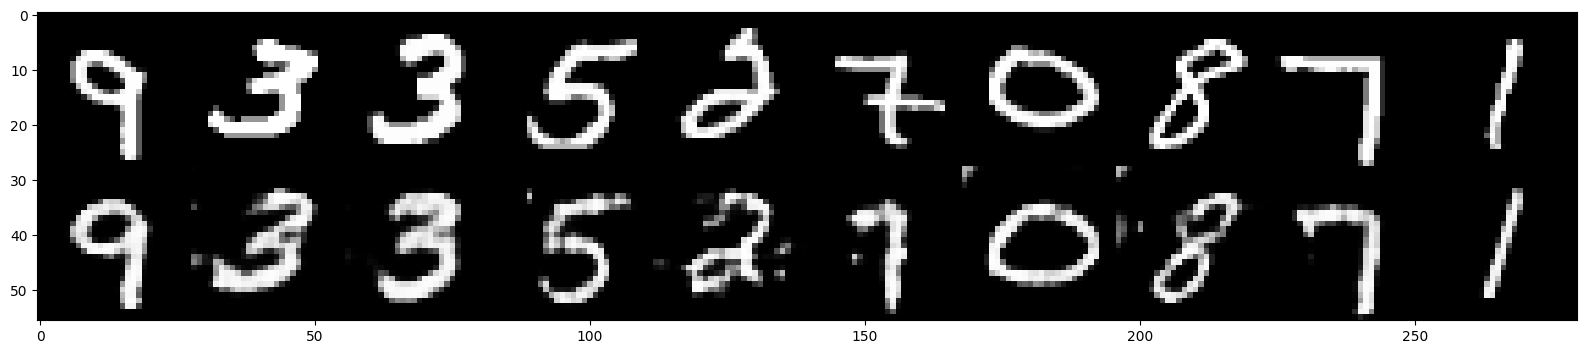

epochs:  41 loss:  0.26516178 11.90151 0.0015891083


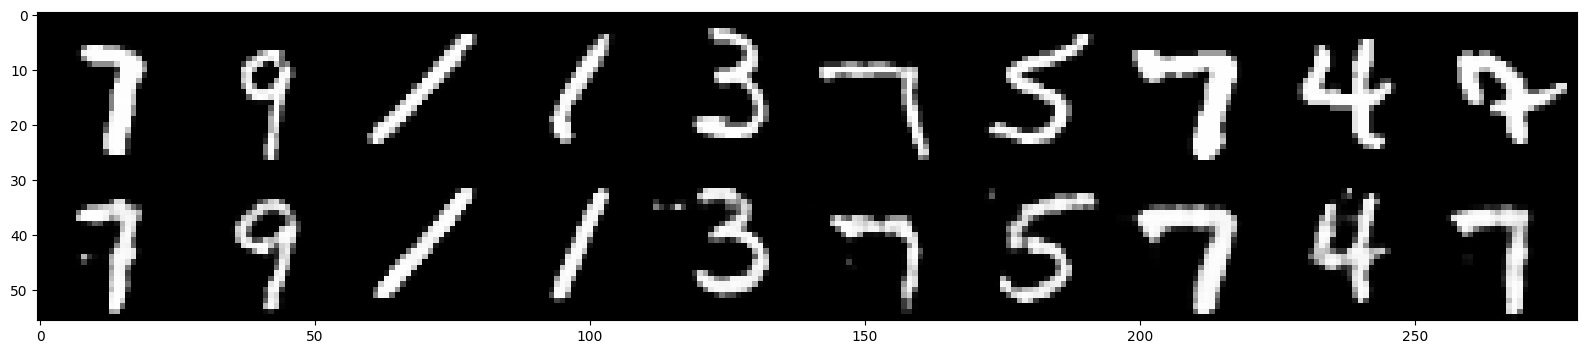

epochs:  42 loss:  0.24238989 11.832677 0.0023131825


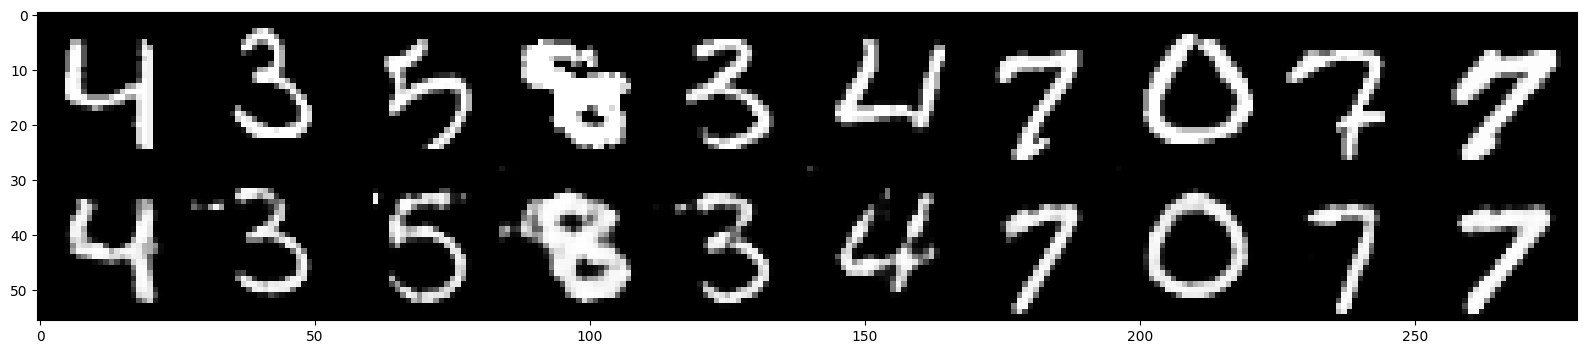

epochs:  43 loss:  0.24295972 11.888578 0.002494272


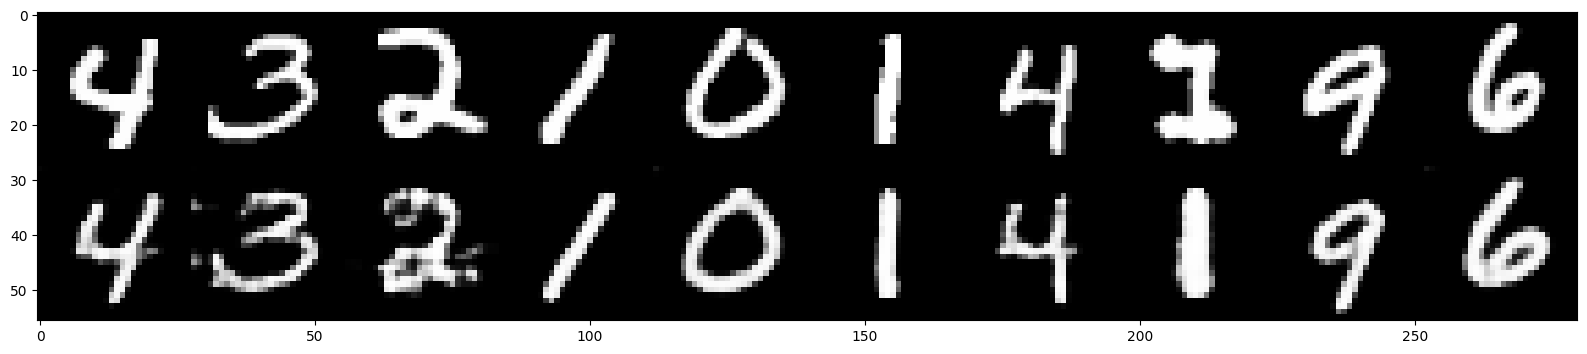

epochs:  44 loss:  0.24447806 12.000205 0.0027104046


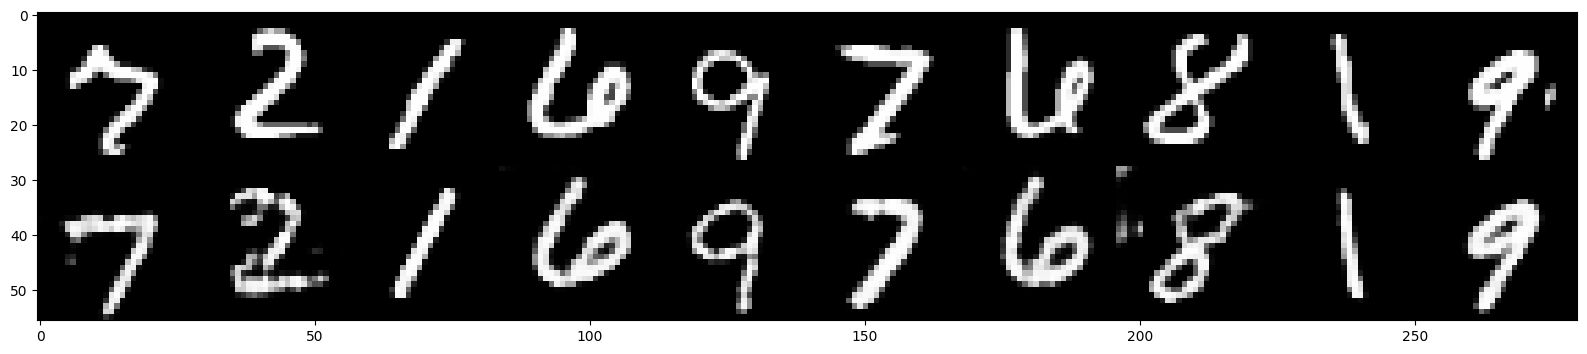

epochs:  45 loss:  0.24218968 12.041099 0.002740962


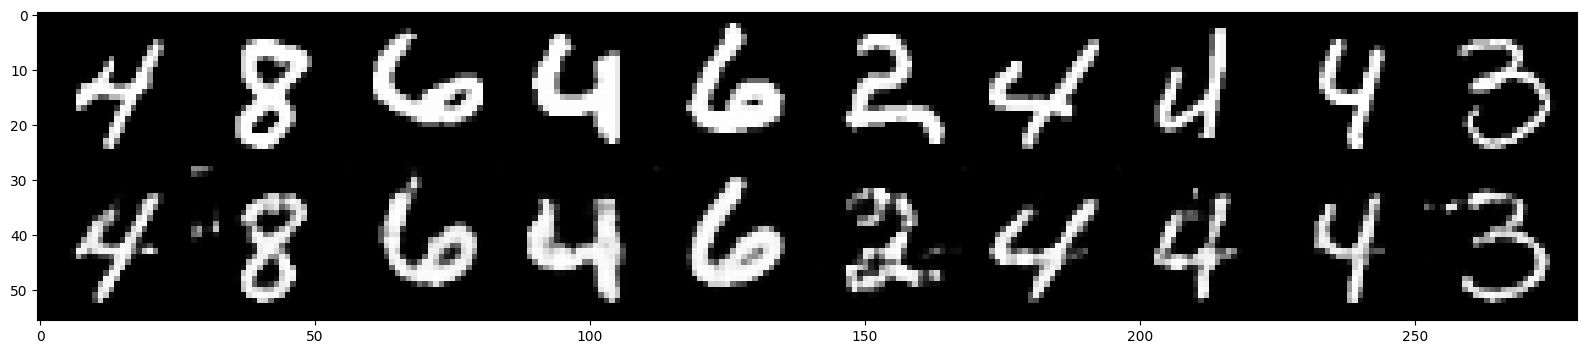

epochs:  46 loss:  0.25264236 11.759082 0.0022463105


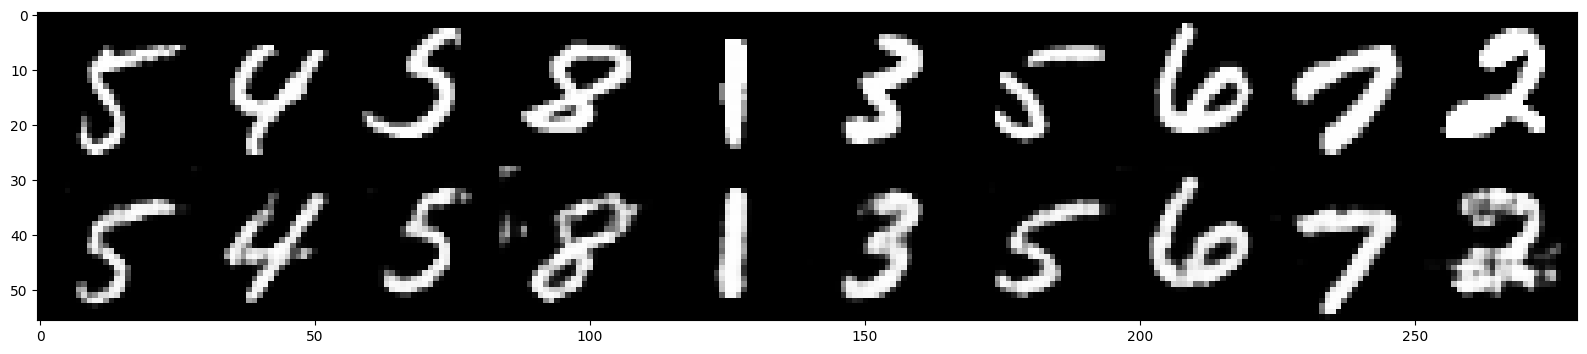

epochs:  47 loss:  0.25426692 11.88858 0.005778785


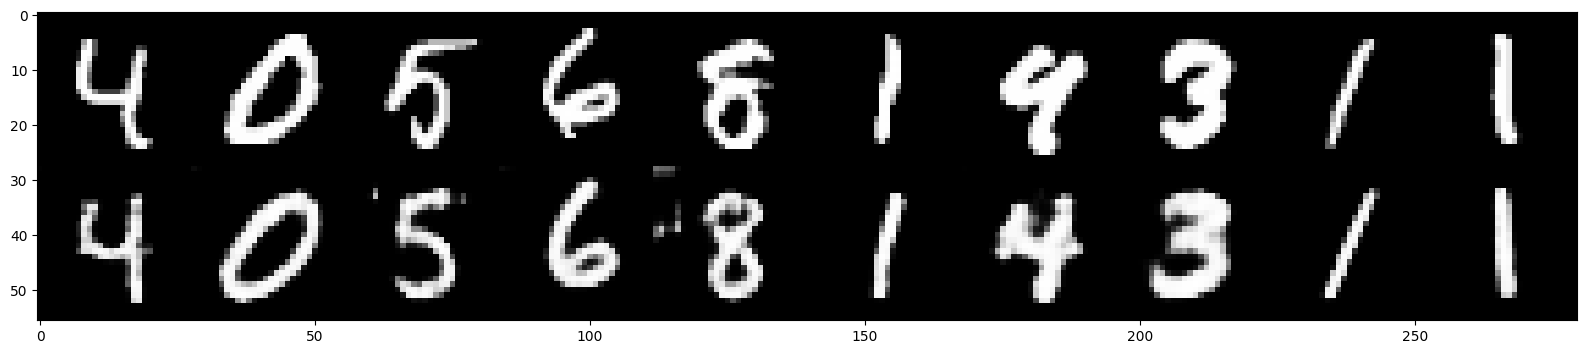

epochs:  48 loss:  0.27052322 11.805892 0.0029020018


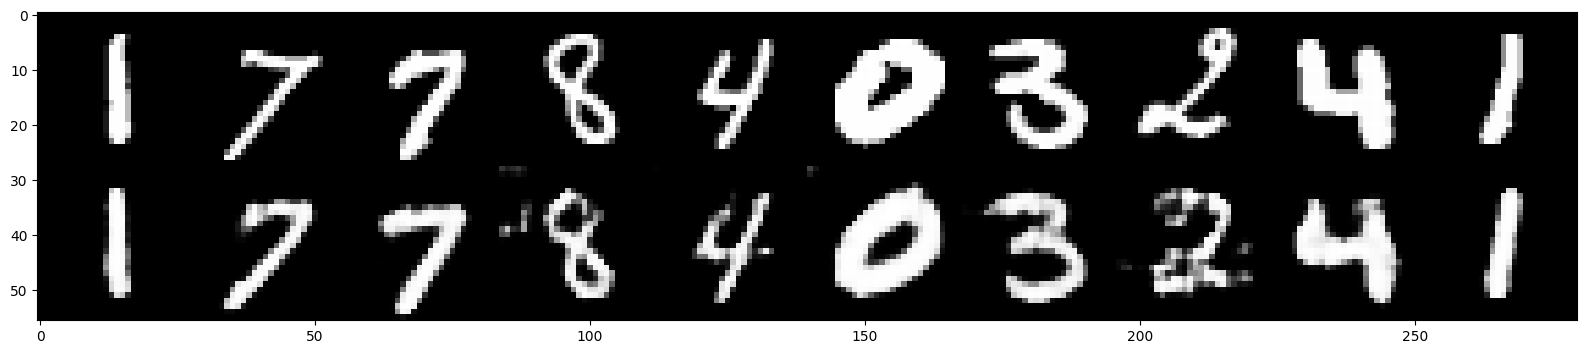

epochs:  49 loss:  0.25584602 11.840245 0.0023235672


In [10]:
vae_step = 4
dis_step = 1

steps = int(len(x_train) / (batch_size * (vae_step + dis_step)))

epochs = 50


for e in range(epochs):
    for i in range(steps):

        for j in range(dis_step):
            xb, yb = next(train_batches_it)
            zp = np.random.randn(batch_size, latent_dim)
            l_g = step_d(xb, yb, zp)



        for j in range(vae_step):
            xb, yb = next(train_batches_it)
            zp = np.random.randn(batch_size, latent_dim)
            l_p, zx, l_d, l_g = step(xb, yb, zp)


    display_digits()
    print('epochs: ', e, 'loss: ', l_p, l_d, l_g)